# Mount google drive

In [1]:
# References:
# [1] https://towardsdatascience.com/different-ways-to-connect-google-drive-to-a-google-colab-notebook-pt-1-de03433d2f7a
# [2] https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab
# [3] https://stackoverflow.com/questions/53581278/test-if-notebook-is-running-on-google-colab

try:
    from google.colab import drive
    from google.colab import files

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:

    # mount google drive 
    drive.mount('/content/gdrive/', force_remount=True)

    !python -m spacy download pt_core_news_lg

    import os
    #change directory
    try:
        os.chdir('/content/gdrive/MyDrive/MCED/ADC')

    except:
        os.chdir('/content/gdrive/MyDrive/ADC')

# Import modules

In [2]:
import os
import pandas as pd
import numpy as np

# import re
# from bs4 import BeautifulSoup, SoupStrainer

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm, trange

import time

import scipy
from scipy.sparse import csr_matrix

import copy

import pt_core_news_lg # NLP
import spacy


In [3]:
# working directory
bdir = os.getcwd()

DF_MSTheses_dir = bdir +'/DF_MSTHESES/'
DF_MSTheses_dir

'h:\\My Drive\\MCED\\ADC/DF_MSTHESES/'

In [4]:

dict_unis = {
            'UPorto'    : "rabertoup",          # "Repositório Aberto da Universidade do Porto (34682)"
            'UCoimbra'  : "estudogl",           # "Estudo Geral - Universidade de Coimbra (20368)"
            'ULisboa'   : "ul",                 # "Repositório da Universidade de Lisboa (17436)"
            'UNLisboa'  : "run",                # "Repositório Institucional da UNL (14415)"
            'UMinho'    : "rum",                # "RepositóriUM - Universidade do Minho (13845)"
            'UAveiro'   : "ria",                # "RIA - Repositório Institucional da Universidade de Aveiro (13254)"
            'UTL'       : "rutl",               # "Repositório da UTL (12863)"
            'UCP'       : "veritati",           # "Veritati - Repositório Institucional da Universidade Católica Portuguesa (9289)"
            # 'ISCTE'     : "iscte",              # "Repositório ISCTE (8605)"
            # 'IPPorto'   : "recipp",             # "Repositório Científico do Instituto Politécnico do Porto (7858)"
            'UBI'       : "ubibliorum",         # "uBibliorum (6998)"
            'UEvora'    : "uevora",             # "Repositório Científico da Universidade de Évora (5980)"
            'UTAD'      : "utad",               # "Repositório da UTAD (5525)"
            # 'IPLisboa'  : "ripl",               # "Repositório Científico do Instituto Politécnico de Lisboa (5232)"
            # 'Lusófona'  : "recil",              # "ReCiL - Repositório Científico Lusófona (5002)"
            # 'UFPessoa'  : "ufp",                # "Repositório Institucional - Universidade Fernando Pessoa (4170)"
            'UAlg'      : "sapientia",          # "Sapientia - Universidade do Algarve (3643)"
            # 'ISPA'      : "ispa",               # "Repositório do ISPA - Instituto Universitário (3367)"
            # 'IPCoimbra' : "ipc",                # "Instituto Politécnico de Coimbra (3053)"
            # 'ICOnline'  : "iconline"            # "IC-online (2688)"
       }

In [5]:
dict_unis.keys()


dict_keys(['UPorto', 'UCoimbra', 'ULisboa', 'UNLisboa', 'UMinho', 'UAveiro', 'UTL', 'UCP', 'UBI', 'UEvora', 'UTAD', 'UAlg'])

# Auxiliary functions

In [6]:
def clean_list(l):
    # return np.nan if l =='[]' else l[2:-2].split("', '")
    return [] if l =='[]' else l[2:-2].split("', '")


def clean_link (s):
    s = s[2:-2].split('), (')
    l = []
    for pair in s:
        l.append(pair[1:-1].split("', '") )
    
    return l


In [7]:
# function to map collections to UO
def collection2UO(l_in, university, dict_collections):

    n_errors = 0
    l_out = []
    for collection in l_in:
        try:
            l_out.append(university + ' | ' + dict_collections[collection[0]])
        except:
            n_errors += 1
            continue

    # print(f'Entries not found in the dictionary: {n_errors}')
    return list(set(l_out))


# function to map collections to Faculty
def collection2Fac(l_in, university, dict_collections):

    n_errors = 0
    l_out = []
    for collection in l_in:
        try:
            l_out.append(dict_collections[collection[0]])
        except:
            n_errors += 1
            continue

    # print(f'Entries not found in the dictionary: {n_errors}')
    return list(set(l_out))



# function to map collections to UO
def item2index(l_in, dict_items):

    n_errors = 0
    l_out = []

    try:
        for item in l_in:
            try:
                l_out.append(dict_items[item])
            except:
                n_errors += 1
                continue
    except:
        return l_out 

    # print(f'Entries not found in the dictionary: {n_errors}')
    return list(set(l_out))


# NLP function

In [8]:
# function to map collections to UO
def abstractNER(l_in, label):

    l_label = []
    
    if len(l_in) > 0:
        nlp = pt_core_news_lg.load()

        doc = nlp(l_in[0])


        for ent in doc.ents:
            if ent.label_ == label:
                # print(ent.text, ent.start_char, ent.end_char, ent.label_)
                l_label.append(ent.text)

    return l_label

In [9]:

def read_df (university, dir):

    # read dataframe
    df = pd.read_csv(dir +'df_MSTheses_' + university +'.csv').drop('Page', axis=1)
    print(f'Successfuly loaded {university} dataframe')

    # columns to clean
    l = ['Author','Supervisor','Title','TitleALT','Language','Date','Abstract','AbstractALT','Keywords','Faculty','Degree','Type','TID','Subject FOS']

    # clean the columns
    for col in l:
        df[col] = df[~df[col].isna()][col].apply(lambda l: clean_list(l))

    df.Collection = df.Collection.apply(lambda x: clean_link(x))

    # Dictionary of collections : UO
    try:
        df_Coll = pd.read_csv(dir + 'dict_Collections_' + university + '.csv')
        dict_Coll = dict(zip(df_Coll.Title, df_Coll.UO))
        
    except Exception as e:
        return e

    
    df['UO'] = df['Collection'].apply(lambda x: collection2UO(x, university, dict_Coll))
    # https://stackoverflow.com/questions/13331698/how-to-apply-a-function-to-two-columns-of-pandas-dataframe

    df['n_UO'] = df['UO'].apply(lambda x: len(x))


    df['Fac'] = df['Collection'].apply(lambda x: collection2Fac(x, university, dict_Coll))
    # https://stackoverflow.com/questions/13331698/how-to-apply-a-function-to-two-columns-of-pandas-dataframe


    return df, dict_Coll

# Load dataframes

In [10]:
# Load dataframes

dict_df_MSTheses = {}
dict_Collections = {}

n_theses = 0

for university in dict_unis.keys():
    # read dataframe
    df, dict_Coll = read_df (university, DF_MSTheses_dir)

    dict_df_MSTheses[university] = df
    dict_Collections[university] = dict_Coll

    n_theses += len(df)

    print(f'{university} df length: {len(df)}')

print(f'Total number of MScTheses: {n_theses}')




Successfuly loaded UPorto dataframe
UPorto df length: 34611
Successfuly loaded UCoimbra dataframe
UCoimbra df length: 20356
Successfuly loaded ULisboa dataframe
ULisboa df length: 17426
Successfuly loaded UNLisboa dataframe
UNLisboa df length: 14415
Successfuly loaded UMinho dataframe
UMinho df length: 13837
Successfuly loaded UAveiro dataframe
UAveiro df length: 13248
Successfuly loaded UTL dataframe
UTL df length: 12853
Successfuly loaded UCP dataframe
UCP df length: 9281
Successfuly loaded UBI dataframe
UBI df length: 7007
Successfuly loaded UEvora dataframe
UEvora df length: 5979
Successfuly loaded UTAD dataframe
UTAD df length: 5524
Successfuly loaded UAlg dataframe
UAlg df length: 3643
Total number of MScTheses: 158180


# NER

In [11]:
    
# for university in dict_df_MSTheses:

# university = 'UAlg'

# df = dict_df_MSTheses[university]
# NLP
# NER in abstracts
# LOC locations
# df['ORG'] = df['Title'].apply(lambda x: abstractNER(x, 'ORG'))
# ORG locations
# df['LOC'] = df['Abstract'].apply(lambda x: abstractNER(x, 'LOC'))

In [12]:
university = 'UAlg'
df = dict_df_MSTheses[university]

idx = 0

l_in = df.iloc[idx].Abstract

print(df.iloc[idx].Title[0])
print(l_in[0])

abstractNER(l_in, 'LOC')


A consociação de espécies como ferramenta para a otimização do uso do ferro
A clorose férrica é um dos problemas agronómicos mais relevantes na região do Mediterrâneo, com elevadas prejuízos para as culturas. Face a esta carência, as plantas dividem-se em duas estratégias para solucionar este problema: Estratégia I ou estratégia de redução (dicotiledóneas) e estratégia II ou estratégia complexante (gramíneas). Nesta última, os fitosideróforos são excretados pelas raízes e dão origem a complexos estáveis de Fe, facilitando a sua absorção. Desenvolveu-se então, um ensaio com uma consociação entre Poa pratensis L. (nome comum: cabelo-de-cão-de-colmo-liso) (estratégia I) e Brassica oleraceae var. italica Plenck (nome comum: couve-brócolos) (estratégia II), de forma a testar a hipótese da hortícola conseguir beneficiar da formação destes complexos gerados pela gramínea. Este contemplou 6 modalidades, com 3 concentrações diferentes de Fe na solução nutritiva (Fe0, Fe1 e Fe5), cada concentraç

['Mediterrâneo', 'Fe', 'Poa', 'Fe', 'Fe', 'Fe', 'Fe']

# Pre-processing

In [13]:
# UPorto
# U.Porto's supervisor is included in the authors list
#

university = 'UPorto'
df = dict_df_MSTheses[university]

df['Supervisor'] = df['Author'].apply(lambda x: x[1:])

dict_df_MSTheses[university] = df

In [14]:
df_MSTheses = pd.DataFrame()


for university in dict_df_MSTheses:
    
    df_MSTheses = pd.concat([df_MSTheses, dict_df_MSTheses[university]], ignore_index=True)

print(f'Total number of MScTheses: {len(df_MSTheses)}')


Total number of MScTheses: 158180


In [15]:
# Counts the number of supervisors

df_MSTheses['n_Sup'] = df_MSTheses['Supervisor'].apply(lambda x: len(x))

# Loads treated KW

In [16]:
df_MSTheses['KW_original'] = df_MSTheses['Keywords']
df_MSTheses = df_MSTheses.drop(['Keywords'], axis = 1)

In [17]:
df_KW_NLP = pd.read_csv('keywords_nlp.csv')

In [18]:
df_KW_NLP.head(50)

,Unnamed: 0,Index,Keywords_Pt,URL
0,0,126447,"""Abordagem político-institucional""",https://www.repository.utl.pt/handle/10400.5/1...
1,6,126447,"""Efeitos dominó"" e ""Endaka""",https://www.repository.utl.pt/handle/10400.5/1...
2,12,126447,"""Estado desenvolvimentista""",https://www.repository.utl.pt/handle/10400.5/1...
3,18,126447,"""Fluxos comerciais""",https://www.repository.utl.pt/handle/10400.5/1...
4,24,126447,"""IDE e ajuda japonesa""",https://www.repository.utl.pt/handle/10400.5/1...
5,30,126447,"""Transportes e telecomunicações""",https://www.repository.utl.pt/handle/10400.5/1...
6,36,35112,"""Comércio do Funchal""",https://estudogeral.sib.uc.pt/handle/10316/994...
7,46,35112,Madeira,https://estudogeral.sib.uc.pt/handle/10316/994...
8,56,35112,Oposição Democrática,https://estudogeral.sib.uc.pt/handle/10316/994...
9,61,66977,"""Design"" de nanopartículas",https://repositorio.ul.pt/handle/10451/46038?m...


In [19]:
l_Index = df_KW_NLP.Index.unique()
len(l_Index)

135414

In [20]:
l_column = []
for idx in l_Index:
    l_kws = sorted(df_KW_NLP[df_KW_NLP['Index'] == idx].Keywords_Pt.to_list())
    URL = df_KW_NLP[df_KW_NLP['Index'] == idx].reset_index(drop = True).loc[0, 'URL']
    l_column.append({'Index': idx, 'Keywords': l_kws, 'URL' : URL })

df_KW = pd.DataFrame(l_column)

In [21]:
df_KW

,Index,Keywords,URL
0,126447,"[""Abordagem político-institucional"", ""Efeitos ...",https://www.repository.utl.pt/handle/10400.5/1...
1,35112,"[""Comércio do Funchal"", Madeira, Oposição Demo...",https://estudogeral.sib.uc.pt/handle/10316/994...
2,66977,"[""Design"" de nanopartículas, Nanopartículas]",https://repositorio.ul.pt/handle/10451/46038?m...
3,51495,"[""Empregorismo"" de Estado, Criação do próprio ...",https://estudogeral.sib.uc.pt/handle/10316/215...
4,77451,"[""Escudo de Protecção da Privacidade UE-EUA"", ...",https://run.unl.pt/handle/10362/20567?mode=full
...,...,...,...
135409,50905,[índrome do nariz vazio],https://estudogeral.sib.uc.pt/handle/10316/852...
135410,38027,[óleo de árvore-do-chá],https://estudogeral.sib.uc.pt/handle/10316/978...
135411,94569,[óleos essenciais],https://repositorium.sdum.uminho.pt/handle/182...
135412,118577,[úlcera gástrica],https://www.repository.utl.pt/handle/10400.5/1...


In [22]:
df_MSTheses = df_MSTheses.join(df_KW.set_index('Index'), how = 'left', rsuffix = '_R')

# https://stackoverflow.com/questions/33199193/how-to-fill-dataframe-nan-values-with-empty-list-in-pandas
df_MSTheses['Keywords'] = df_MSTheses['Keywords'].apply(lambda d: d if isinstance(d, list) else [])
# df_MSTheses['URL_R'] = df_MSTheses['URL_R'].apply(lambda d: d if isinstance(d, list) else [])

df_MSTheses

,URL,Author,Supervisor,Title,TitleALT,Date,Abstract,AbstractALT,Language,Faculty,...,Subject FOS,University,Collection,UO,n_UO,Fac,n_Sup,KW_original,Keywords,URL_R
0,https://repositorio-aberto.up.pt/handle/10216/...,[Guilherme de Jesus Costa],[],[A influência das estatinas no desenvolvimento...,[],[2022-07-11],[],[],[por],[Faculdade de Medicina Dentária],...,"[Ciências médicas e da saúde, Medical and Heal...",UPorto,"[[FMDUP - Dissertação, /handle/10216/6814], [F...",[UPorto | FMDUP],1,[FMDUP],0,"[Ciências médicas e da saúde, Medical and Heal...",[Ciências médicas e da saúde],https://repositorio-aberto.up.pt/handle/10216/...
1,https://repositorio-aberto.up.pt/handle/10216/...,[Leonor Torres dos Santos Hipólito Reis],[],[Sales and Operations Planning: aplicação de u...,[],[2022-07-22],[],[],[por],[Faculdade de Engenharia],...,[Ciências da engenharia e tecnologias::Outras ...,UPorto,"[[FEUP - Dissertação, /handle/10216/6812], [FE...",[UPorto | FEUP],1,[FEUP],0,"[Outras ciências da engenharia e tecnologias, ...",[Outras ciências da engenharia e tecnologias],https://repositorio-aberto.up.pt/handle/10216/...
2,https://repositorio-aberto.up.pt/handle/10216/...,[Uindinéa Pedroza Almeida],[],[Cidade educadora na contemporaneidade: a expe...,[],[2022-07-15],[Desde o seu surgimento as cidades têm passado...,[],[por],[Faculdade de Psicologia e de Ciências da Educ...,...,"[Ciências sociais::Ciências da educação, Socia...",UPorto,"[[FPCEUP - Dissertação, /handle/10216/6811], [...",[UPorto | FPCEUP],1,[FPCEUP],0,"[Ciências da educação, Educational sciences]",[Ciências da educação],https://repositorio-aberto.up.pt/handle/10216/...
3,https://repositorio-aberto.up.pt/handle/10216/...,[Rita Catarina da Silva Almeida de Carvalho],[],[Relatório de Estágio - Serviço de Estomatolog...,[],[2022-07-12],[],[],[por],[Faculdade de Medicina Dentária],...,"[Ciências médicas e da saúde, Medical and Heal...",UPorto,"[[FMDUP - Dissertação, /handle/10216/6814], [F...",[UPorto | FMDUP],1,[FMDUP],0,"[Ciências médicas e da saúde, Medical and Heal...",[Ciências médicas e da saúde],https://repositorio-aberto.up.pt/handle/10216/...
4,https://repositorio-aberto.up.pt/handle/10216/...,[Miguel Viamonte Santos da Costa Fernandes],[],[Design de Uma App Planeadora de Rotas Multicr...,[],[2022-10-07],[],[],[por],[Faculdade de Engenharia],...,[Ciências da engenharia e tecnologias::Outras ...,UPorto,"[[FEUP - Dissertação, /handle/10216/6812], [FE...",[UPorto | FEUP],1,[FEUP],0,"[Outras ciências da engenharia e tecnologias, ...",[Outras ciências da engenharia e tecnologias],https://repositorio-aberto.up.pt/handle/10216/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158175,https://sapientia.ualg.pt/handle/10400.1/8474?...,"[Ribeiro, Maria Laura Braga]","[Planas, Miguel, Wallace, Jeff]",[Efeito da privação alimentar sobre alguns com...,[],[1994],"[Através da análise do crescimento, do conteúd...","[Através da análise do crescimento, do conteúd...",[por],[Universidade do Algarve. Unidade de Ciências ...,...,[Domínio/Área Científica::Ciências Naturais::O...,UAlg,"[[UAlg, /handle/10400.1/2680], [UAlg-Teses, /h...",[UAlg | ICArEHB],1,[ICArEHB],2,"[Aquacultura, Pregado, Scophthalmus maximus, C...","[Alimentação, Crescimento, Privação alimentar]",https://sapientia.ualg.pt/handle/10400.1/8474?...
158176,https://sapientia.ualg.pt/handle/10400.1/6768?...,"[Galhardo, Amélia Cristina C.C. da Ponte]","[Castro, Margarida]","[Estudo da biologia e da pescaria da lagosta, ...",[],[1994],[Este trabalho constitui um estudo preliminar ...,[Este trabalho constitui um estudo preliminar ...,[por],[Universidade do Algarve. Unidade de Ciências ...,...,[],UAlg,"[[UAlg, /handle/10400.1/2680], [UAlg-Teses, /h...",[UAlg | ICArEHB],1,[ICArEHB],1,"[Lagosta, Palinarus elephas, Relações alométri...","[Período ovígero, Relações alométricas, Época ...",https://sapientia.ualg.pt/handle/10400.1/6768?...
158177,https://sapientia.ualg.pt/handle/10400.1/7362?...,"[Brinca

In [23]:
# for iter, row in df.iterrows():
#     if row.URL != row.URL_R:
#         print(iter, row.URL, row.URL_R)

In [24]:
import random

id = random.randint(0,len(df))

print(id)

print(df_MSTheses.iloc[id].KW_original)

print(df_MSTheses.iloc[id].Keywords)

29619
['Cadeiras de rodas', 'Inteligência artificial', 'Reconhecimento facial']
['Inteligência artificial', 'Reconhecimento facial']


# Separates the Year

In [25]:
df_MSTheses['Year'] = df_MSTheses['Date'].apply(lambda x: x[0])
df_MSTheses['Year'] = pd.to_datetime(df_MSTheses['Year'], utc=True)
df_MSTheses['Year'] = df_MSTheses['Year'].dt.year

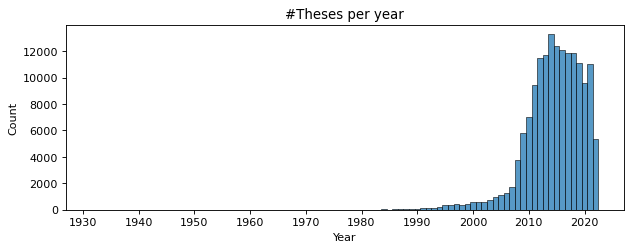

In [26]:
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib
from matplotlib.pyplot import figure
figure(figsize=(9, 3), dpi=80)

ax = plt.axes()
sns.histplot(data=df_MSTheses[['Author','Year']], x="Year", discrete = True)
ax.set_title('#Theses per year')
xticks = np.arange(1930,2030,10)
ax.set_xticks(xticks)
plt.savefig(bdir + '/Theses_year.png')
plt.show()

In [27]:
df_MSTheses_year = df_MSTheses[['Author','Year']].groupby(by = ['Year']).count()
df_MSTheses_year

,Author
Year,
1932,1
1943,1
1945,1
1977,1
1980,1
1982,2
1983,2
1984,22
1985,21


In [28]:
year_init = 2010
print(f'Total number of MScTheses: {len(df_MSTheses)}')
df_MSTheses = df_MSTheses[df_MSTheses['Year'] > year_init]
df_MSTheses = df_MSTheses.reset_index(drop = True)
print(f'Total number of MScTheses after {year_init}: {len(df_MSTheses)}')

Total number of MScTheses: 158180
Total number of MScTheses after 2010: 131181


# Counts the number of MScTheses

In [29]:
# counts the number of times item appears in the lists of column col

def count_theses(df, col):

    # dictionary of counts
    dict_count =  {}

    # list of failures
    l_failures = []

    # column of interest in the df
    l_col = df[col]

    # loops each row
    for iter in tqdm(l_col.index):
        try:
            # loops each list of column col
            for item in l_col[iter]:
                # if the item is already in the dictionary
                try:
                    dict_count[item] += 1
                # if not, creates the item in the dictionary
                except:
                    dict_count[item] = 1

        except:
            l_failures.append(iter)

    df_out = pd.DataFrame(zip(dict_count.keys(), dict_count.values()), columns = [col,'Count'])
    df_out = df_out.sort_values(by = col, ignore_index=True)
    
    return df_out, l_failures

# Table Social Network

In [30]:
# counts the number of times item appears in the lists of column col

def table_SN(df, col):

    # list of rows
    l_rows =  []

    # list of failures
    l_failures = []

    # column of interest in the df
    l_col = df[col]

    # loops each row
    for iter in tqdm(df.index):
        try:
            # loops each list of column col
            for item in df.loc[iter,col]:
                dict_row ={
                    'University'    : df.loc[iter,'University'],
                    'Fac'           : df.loc[iter,'Fac'],
                    'Keyword'       : item,
                    'Year'          : df.loc[iter,'Year'],
                    'nUO'           : df.loc[iter,'n_UO'],
                    'nSup'          : df.loc[iter,'n_Sup'],
                }
                l_rows.append(dict_row)

        except:
            l_failures.append(iter)

    df_out = pd.DataFrame(l_rows)
    
    return df_out, l_failures

In [31]:
# col = 'Keywords'
# df_SN, l_fails = table_SN(df_MSTheses, col)

# df_SN.to_csv('df_SN.csv', index = True)

# df_SN.head()

# Change working directory


In [32]:
wdir = bdir + '/REL_DIST/' 
os.chdir(wdir)

# Connectivity tables

A connectivity table has M rows, corresponding to the number of MScTheses and N columns, corresponding to a given list of items (UO, supervisors, keywords).
At location i,j the table is filled with 1 if the MScThesis of row i is associated with the item of column j. 

In [33]:
from scipy.sparse import csr_matrix
import scipy

# Creates connectivity matrix where each elment i,j is the count of common items between i and j
#  
def connect_table_csr(df, df_col):

    # https://numpy.org/doc/stable/reference/generated/numpy.zeros.html
    # https://numpy.org/doc/stable/reference/arrays.scalars.html#numpy.uint64
    #

    # dictionary of values vs index
    dict_col = dict(zip(df_col.iloc[:,0], df_col.index))
    
    # column name
    col = df_col.columns[0]
    # column of interest in the df
    l_col = df[col]

    data = []
    row_ind = []
    col_ind = []

    # list of failures
    l_failures = []
    
    # loops each row
    for i in tqdm(l_col.index):
        # loops each list of column col
        for item in list(set(l_col[i])):
            # if the item is already in the dictionary
            try:
                col_ind += [dict_col[item]]
                data += [1.0]
                row_ind += [i]
                
            # if not, creates the item in the dictionary
            except:
                l_failures.append(i)

    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html#scipy.sparse.csc_matrix
    arr = csr_matrix((data, (row_ind, col_ind)), shape= (len(df),len(dict_col)), dtype = 'uint16')

    sparse_coef = np.sum(arr) / (arr.shape[0] * arr.shape[1])

    print(f'Sparcity: {round(sparse_coef*100,3)}%')
    
    return arr, sparse_coef, l_failures

In [34]:
# https://stackoverflow.com/questions/13077527/is-there-a-numpy-delete-equivalent-for-sparse-matrices
import numpy as np
from scipy.sparse import csr_matrix

def delete_from_csr(mat, row_indices=[], col_indices=[]):
    """
    Remove the rows (denoted by ``row_indices``) and columns (denoted by ``col_indices``) from the CSR sparse matrix ``mat``.
    WARNING: Indices of altered axes are reset in the returned matrix
    """
    if not isinstance(mat, csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")

    rows = []
    cols = []
    if row_indices:
        rows = list(row_indices)
    if col_indices:
        cols = list(col_indices)

    if len(rows) > 0 and len(cols) > 0:
        row_mask = np.ones(mat.shape[0], dtype=bool)
        row_mask[rows] = False
        col_mask = np.ones(mat.shape[1], dtype=bool)
        col_mask[cols] = False
        return mat[row_mask][:,col_mask]
    elif len(rows) > 0:
        mask = np.ones(mat.shape[0], dtype=bool)
        mask[rows] = False
        return mat[mask]
    elif len(cols) > 0:
        mask = np.ones(mat.shape[1], dtype=bool)
        mask[cols] = False
        return mat[:,mask]
    else:
        return mat

In [35]:
# copy original df
df_base = copy.deepcopy(df_MSTheses[['URL', 'Year', 'Supervisor', 'UO', 'Keywords']]) 


dict_columns = {
                'KW' : 'Keywords',
                'S'  : 'Supervisor',
                'UO' : 'UO',
}

dict_nTheses = {
                'KW' : 2,
                'S'  : 2,
                'UO' : 1,
}


# dictionary of dataframes
dict_df={}
dict_tables={}


# Loops all relevant columns and counts the number of theses 


for key_col in dict_columns:
    
    col = dict_columns[key_col]
    print('###############################################################################')
    print(f'Processing column {key_col} : {col}')

    df, l_fails = count_theses(df_base, col)
    print(f'Number of unique {col}: {len(df)}')

    nTheses = dict_nTheses[key_col]
    strTheses = 'thesis' if nTheses == 1 else 'theses'
    
    df = df[df['Count'] >= nTheses].reset_index(drop = True)
    print(f'Number of {col} who show up in {nTheses} {strTheses} or more:{len(df)}')

    dict_df[key_col] = df

    table, scoef, l_fails = connect_table_csr(df_base, df)
    dict_tables[key_col] = table

#########################################################################################
print('###############################################################################')
print('Saving files')
for key_col in dict_columns:
    dict_df[key_col].to_csv(f'df_Theses_{key_col}.csv', index = False)
    scipy.sparse.save_npz(f'table_{key_col}_s.npz', dict_tables[key_col])

df_base.to_csv('df_base.csv', index = False)

###############################################################################
Processing column KW : Keywords


100%|██████████| 131181/131181 [00:00<00:00, 143759.08it/s]


Number of unique Keywords: 109510
Number of Keywords who show up in 2 theses or more:25437


100%|██████████| 131181/131181 [00:01<00:00, 116915.38it/s]


Sparcity: 0.007%
###############################################################################
Processing column S : Supervisor


100%|██████████| 131181/131181 [00:00<00:00, 173513.87it/s]


Number of unique Supervisor: 30661
Number of Supervisor who show up in 2 theses or more:14861


100%|██████████| 131181/131181 [00:00<00:00, 148226.68it/s]


Sparcity: 0.006%
###############################################################################
Processing column UO : UO


100%|██████████| 131181/131181 [00:00<00:00, 191784.21it/s]


Number of unique UO: 117
Number of UO who show up in 1 thesis or more:117


100%|██████████| 131181/131181 [00:00<00:00, 160171.97it/s]


Sparcity: 0.619%
###############################################################################
Saving files


# Relational tables

In [36]:
def rel_table(t1, t2, dt):
    """
    t1 - name of sparse table 1
    t2 - name of sparse table 2
    dt - dictionary of tables
    rt - relational table
    """

    # compute the relational table
    rt = dt[t1].transpose().dot(dt[t2]).tocsr() 

    # save to file
    scipy.sparse.save_npz('rel_' + t1 + '_' + t2 + '.npz', rt)

    return rt

# Distance between nodes 

In [37]:
def dist_nodes (mat):
    
    # computes the norms of each column
    # power 2 element wise
    col_norm = mat.power(2)
    # sum of rows
    col_norm = np.sum(col_norm, axis=1)
    # square root provides the norms of each vector
    col_norm = np.sqrt(col_norm)
    # converts to 1D array
    col_norm = np.asarray(col_norm)
    col_norm = np.squeeze(col_norm)

    # normalize the rows
    result = mat.transpose() / col_norm
    result = result.transpose()
    
    # converts to sparse matrix to avoid memory problems
    result = csr_matrix(result)

    # the product of the matrix by itself gives the normalized distance (cos similarity)
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html
    result = result.dot(result.transpose())


    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.setdiag.html
    # result.setdiag(1)

    return result

# Distance matrices for each year

In [38]:
import os


def dist_nodes_year(df_base, dict_tables, dict_df, l_year):

    # if year is an integer, convert to list
    if isinstance(l_year, int):
        l_year = [l_year]
    
    dir_year = f'{l_year[0]} - {l_year[-1]}' if len(l_year) > 1 else f'{l_year[0]}'

    # check for extraction directories existence
    if not os.path.isdir(dir_year):
        os.makedirs(dir_year)

    os.chdir(dir_year)

    idx_year = df_base[df_base['Year'].isin(l_year)].index

    dict_t = copy.deepcopy(dict_tables)

    # delete the empty columns of each table
    for key in dict_t:
        # print(key)
        table = dict_t[key][idx_year]
        # colzeros = np.where(np.squeeze(np.array(np.sum(table, axis = 0))) == 0)[0].tolist()
        # rowzeros = np.where(np.squeeze(np.array(np.sum(table, axis = 1))) == 0)[0].tolist()
        # print(len(colzeros), len(rowzeros))

        # table = delete_from_csr(table, col_indices = colzeros)
        dict_t[key] = table

        # names of the columns that remain
        # df_names = dict_df[key].drop(colzeros).reset_index(drop = True).iloc[:,0]
        # df_names.to_csv('col_names_' + key + '.csv', index = False)

    ######################################################################################################
    # compute the relational tables
    l_pairs = [
            'UO_UO',
            'UO_S',
            'UO_KW',
            'S_KW',
            'S_S',
            'KW_UO',
            'KW_S',
            'KW_KW',
            ]   

    # dictionary of relational tables
    dict_reltab = {}

    for pair in l_pairs:
        pair = pair.split('_')
        relTable = rel_table(pair[0], pair[1], dict_t)
        dict_reltab[f'{pair[0]}_{pair[1]}'] = relTable
        scipy.sparse.save_npz(f'rel_{pair[0]}_{pair[1]}.npz', relTable)
    
    # compute the distance between nodes

    for key in dict_reltab:
        key0 = key.split('_')[0]
        key1 = key.split('_')[1] 

        if  key0 == key1:
            continue
        
        # print(f'Processing {key}')
        # relational table
        mat = dict_reltab[key]

        # drops rows/columns without features
        colzeros = np.where(np.squeeze(np.array(np.sum(mat, axis = 0))) == 0)[0].tolist()
        rowzeros = np.where(np.squeeze(np.array(np.sum(mat, axis = 1))) == 0)[0].tolist()
        # print(len(colzeros), len(rowzeros))

        mat = delete_from_csr(mat, row_indices = rowzeros, col_indices = colzeros)

        # names of the rows/columns that remain
        row_names = dict_df[key0].drop(rowzeros).iloc[:,0]
        row_names.to_csv('row_names_' + key + '.csv', index = False)

        # compute the distances
        dist_mat = dist_nodes(mat)

      # save to file
        scipy.sparse.save_npz('dist_' + key + '.npz', dist_mat)

    return

In [39]:
l_year = sorted(df_base['Year'].drop_duplicates().tolist())

for year in trange(l_year[0], l_year[0] + len(l_year)):
    os.chdir(wdir)
    dir_year = [year]
    dist_nodes_year(df_base, dict_tables, dict_df, dir_year)

100%|██████████| 12/12 [00:32<00:00,  2.70s/it]


In [40]:
# os.chdir(wdir)
# dir_year = [2013]
# dist_nodes_year(df_base, dict_tables, dict_df, dir_year)

In [41]:
os.chdir(wdir)

# dir_year = f'{l_year[0]} - {l_year[-1]}' 

%time dist_nodes_year(df_base, dict_tables, dict_df, l_year)


CPU times: total: 1min 8s
Wall time: 1min 12s
